In [3]:
%pylab inline
import pandas as pd

import numpy as np
from __future__ import division
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

import logging
logger = logging.getLogger()

Populating the interactive namespace from numpy and matplotlib


4 Mining Data Streams
============

Data:    
1. database   
2. stream:     
    + lost forever if the data arrived is not processed immediately or stored.    
    + the data arrives so rapidly that it isn't feasible to store all.   
    
    solution: summarization     
        + sample/filter, then estimate     
        + fixed-length "window"

### 4.1 The Stream Data Model

Examples of Steam Sources:   

+ Sensor Data:      
  Deploy a million sensors    
  
+ Image Data:     
  satellites, surveilance camera

+ Internet and Web Traffic

![Fig 4.1: A data-stream_management system](files/res/figure_4_1.png)

##### 4.1.3 Stream Queries
two ways:

1. standing queries     
   preset, permanetly execting, and produce outputs at appropriate times.    

2. ad-hoc queries    
   a question asked once about the current state of a steam or streams.    
   + a common sample approach is to store a **sliding windows** of each stream in the working store.
  
  
**generalizations** about stream algorithms:

1. Often, an **approximate answer** is much more **efficient** than an **exact solution**.

2. **hash function** introduces useful **randomness** intho the algorithm's behavior $\to$ approximate answer

### 4.2 Sampling Data in a Stream

extract reliable samples from a stream:    
select $S \subset B$, $\, s.t. \, E[f(S)] = E[f(B)]$.

Example   
Prob: What fraction of the typical user's queries were repeated over the past month?     

given: a user has issued $s$ search queries one time, $d$ queries two times, and no queires more than twice.

solutions:

- _REAL_: $$tf = \frac{d}{s+d}$$

- _BAD_: store 1/10 th of the stream **elements**.    
  + for s: $1/10 s$ one time    
  + for d:      
    $(1/10)*(1/10)*d = 1/100 d$ two times,      
    $1/10*9/10 + 9/10*1/10 d = 18/100d$ one time.
  + calc: 
  $$\hat{tf} = \frac{1/100d}{1/10s + 1/100d + 18/100d} = \frac{d}{10s + 19d}$$

- _GOOD_: pick 1/10th of the **users** and take all their searches for the sample.    
  $$\hat{tf} = \frac{d}{s+d}$$     
  
  sample: **hash**    
  obtain a sample consisting of any rational fraction $a/b$ of the users by hashing user names to $b$ buckets. Add the search query to the sample if the hash value is less than $a$.
  
  **The General Sampling Problem**   
  Our steam $x$ consists of tuples with $n$ components $\{x_n\}$(eg: user, query, time), and a subset of the components are the _key_ components $x_k$(eg: user).     
  To take a sample of size $a/b$, we hash the _key_ value $h(x_k)$ for each tuple to $b$ buckets, and accept the tuple if $h(x_k) < a$.
  
  **varying the sample size**    
  storage is limited, while users/queries grows as time goes on  ==> decrease the select fraction $a/b$.    
  
  solution:   
  1. $h(x) = \{0, 1, \dots, B-1\}$, $B$ is sufficient large.    
  2. maintain a threshold $t$, we accept when $h(x) < t$.       
  3. $t = t - 1$ if the allotted space is exceeded. remove all samples $h(x) = t$.    
     [opt] efficient:   
     + lower $t$ by more than 1.    
     + maintaining an index on the hash value to find all those tuples quickly.

### 4.3 Filtering Streams

#### 4.3.2 The Bloom Filter

##### component
0. key values: $ S = \{s_1, s_2, \dotsm, s_m\}$. 

1. array $B$ of $n$ bits, initially all 0's.

2. $h_i(s_j) \in [1, n], \quad i = 1, 2, \dotsm, k$.

##### intialization
1. $B$ are all 0's.

2. $B[h_i(s_j)] = 1$ for every hash function and every key value.

##### test
to test a key $K$:    
if $ALL_{i=1}^{k} (h_i(K)) = 1$, then allow it, $K \in S$;  else reject it.

##### Analysis
we have $n$ targets, $k \times m$ darts.

1. a given dart will NOT hit a given target: $$ P = (n - 1) / n $$

2. all darts will NOT hit a given target: 
   \begin{align}
        P &= (\frac{n-1}{n})^{k m} \\
          &= (1 - \frac{1}{n})^{n \frac{1}{n} k m} \\
          &\approx e^{-\frac{k m}{n}}
   \end{align}
   namely, the possibility of a bit remained 0 is $e^{-\frac{k m}{n}}$. 

3. the possibility of a bit remained 1 is $1 - e^{-\frac{k m}{n}}$.

4. for a key $K$, the possibility of all of bits of $h_i(K)$ remained 1 is: $$ (1 - e^{-\frac{k m}{n}})^{k} $$

conclusion:    
P[false negtive] = 0, P[false positive] = $ (1 - e^{-\frac{k m}{n}})^{k} $.

### 4.4 Counting Distinct Elements in a Stream
Solution:

1. keep a list of all the elements seens so far in main memeory. $\gets$ the number of distinct elements is not too great.

2. use more machines.

3. the Flajolet-Martin algorithm.


#### 4.4.2 the Flajolet-Martin Algorithm
**tail length** for $a$ and $h$:     
the number of 0's at the end of the bit string $h(a)$,      
where $a$ is a stream element, and $h$ is a hash function which maps the elements of an universal set to a bit-string that is sufficiently long. 

**estimate**:     
We use estimate $2^R$ for the number of distinct elements seen in the stream,   
where $R$ is the maximum tail length of any $a$ seen so far in the stream.

**original idea**:    
$\text{different elements }\uparrow \implies \text{ different bit-string } h(a) \uparrow \implies \text{ "unusual" value occurs } \implies $ use unusual properity to estimate.  

##### Analysis
1. for a given $a$, the probility of $h(a)$ ending in at least $r$ 0's is: $(\frac{1}{2})^r$.

2. for $m$ distinct elements, the probility of none of them ending in at least $r$ 0's is: 
   \begin{align}
       \neg P &= (1 - (\frac{1}{2})^r)^m \\
         &= (1 - 2^{-r})^{2^r 2^{-r} m} \\
         &\approx e^{-\frac{m}{2^r}}
   \end{align}

3. the probility of at least one of them ending in at least $r$ 0's is: $P = 1 - e^{-\frac{m}{2^r}}$

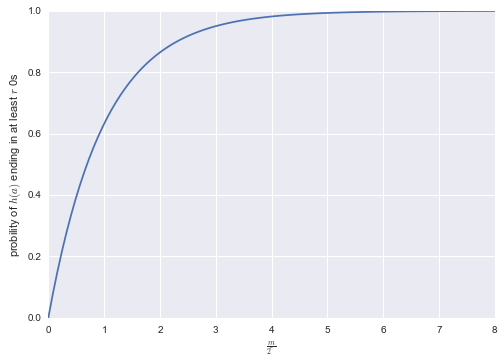

In [23]:
x = np.linspace(0, 8, 100)

p = 1 - np.exp(-x)

plt.plot(x, p)
plt.xlabel(r'$\frac{m}{2^r}$')
plt.ylabel(r'probility of $h(a)$ ending in at least $r$ 0s')

namely,    
\begin{equation}
    P \to \begin{cases}
        1 \quad \text{if } m \gg 2^r \\
        0 \quad \text{if } m \ll 2^r
    \end{cases}
\end{equation}
hence, $2^R$ is unlikely to be either much too high or much too low.


##### Combining Estimates
Suppose we have $k$ hash functions, then $k$ estimates $E_i$ of $m$ are obtained, but how to combine those estimates?

Solutions:

1. Average(E_i)   
   cons: overestimate $\Leftarrow$ if $E_p \gg m \gg E_q$, $Ave(E_p, E_q) \to E_p$.
   
2. Median(E_i)    
   cons: estimate is always a power of 2.
   
3. hybrid      
   1. group $h_i$ to $b$ buckets containing $x$ hash functions.    
      $x \geq C log_2 m$ in order to guarantee that any possible average can be obtained.
   2. average $E(h_i)$ in every buckets, obtain $E_b$.   
   3. $\text{median}(E_b) \approx m$ when $b$ is sufficiently large,     

space requirements:     
keep one integer $R$ per hash function.    

in practice, the **time** it takes to compute hash values would be the more significant limitation on the **number** of hash functions we use.

### 4.5 Estimating Moments

suppose we have a stream $s = e_1 e_2 \dotsm e_n \in {S}^n$.

**kth-order moment** = $\sum_{i \in S} m_i^k$,     
where $m_i$ is the number of occurrences of the $i$-th element in $S$.


Example: 

1. 0th moment: the number of distinct elements, define $0^0 = 0$.

2. 1th moment: the length of the stream.

3. 2nd moment: named the *surprise number*, since it measure how uneven the distribution of elements in the stream is.


#### 4.5.2 The Alon-Matias-Szegedy Algorithm for Second Moments

We compute some number of variables,    
for each variable $X$, we store:  

1. $X.element \in S$.

2. $X.value = 1 + \sum_{i=k+1}^{n} I(e_i = X.element)$    
   where $k = random(1,n)$ and $X.element = e_k$.   
   
   namely, $X.value$ is the times $e_i$ picked randomly occurs in the position among $i, i+1, \dotsc, n$.
   
an **estimate** of the 2nd moment from any variable $X$ is: $$ E_x = n(2 X.value - 1)$$    
2nd moment $\gets Ave_{x \in S} (E_x)$


##### Analysis: Why it works
Let $s = e_1 e_2 \dotsm e_n$, and $e \in S = {S_1, S_2, \dotsc, S_u}$.     
    $c_i$ is the number of times $e_i$ appears among positions $i, i+1, \dotsc, n$.
    
for any picked position $i$,  
\begin{align}
    E[n(2X.value - 1)] &= n(2 E[X.value] - 1) \\
                       &= n(2 \frac{1}{n} \sum_{i=1}^{n} (c_i) - 1) \\
                       &= \sum_{i=1}^{n} (2 c_i - 1) \\
                       &\text{for every $S_j$, existing an arithmetic progression } \sum_a 1+3+ \dotsb + (2m_a -1) \\
                       &= \color{red}{ \sum_{j=1}^{u} \sum_{k=1}^{m_{S_j}} (2k - 1) } \\
                       &= \sum_{j=1}^{u} \frac{m_{S_j}}{2} (1 + (2 m_{S_j} - 1)) \\
                       &= \sum_{j=1}^{u} m^2_{S_j} \quad = \text{ 2nd moment}
\end{align}


##### Higher-Order Moments
for any $k \geq 2$ and $v = X.value$,     
estimate $k$th moments is $$n (v^k - (v-1)^k)$$.

because for given a, $\sum_{v=1}^{m_a} (v^k - (v-1)^k) = m_a^k$.


#### 4.5.5 Dealing With Infinite 
In practice, $n$ is not fixed, but it grows with time.       

+ store variable: $> log_2 n$ bits.    

+ break the condition: every position is picked in **equal probility**.  


**Solution**:   
idea: maintain as many variable $X$ as possible at all times, and to throw some out as the stream grows.

Suppose we have space to store $s$ variables, and we have seen $n$ stream elements.     
hence, the probility of any particular position is picked is $\frac{s}{n}$.

When the $(n+1)$th element arrivs, pick that position with probility $\frac{s}{n+1}$.    
+ if not picked, $s$ remained.    
+ if picked, one of $s$ is ruled out in equal probility, and replaced by the $(n+1)$ position of element $e(n+1)$ with initial value $1$.  


**Analysis**: how the solution correct the probility of any position picked?    

1. for the $(n+1)$th position, the probility of being picked is: $$\frac{s}{n+1}$$

2. for the original $s$ position, the probility of being picked(remained) is: 
$$ \frac{s}{n} (1 - \frac{s}{n+1} \frac{1}{s}) = \frac{s}{n+1} $$



### 4.6 Counting Ones in a Window